In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import math
import seaborn as sns

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('JUIndoorLoc-Training-data.csv')
df_test = pd.read_csv('JUIndoorLoc-Test-data.csv')

In [4]:
df.shape, df_test.shape

((23904, 177), (1460, 177))

In [7]:
split_cols = df['Cid'].str.lstrip('L').str.split('-', expand=True)
split_cols.head(3)

,0,1,2
0,4,40,1
1,4,40,1
2,4,40,1


In [8]:
# Step 2: Assign new columns
df['floor'] = split_cols[0].astype(int)  # floor as integer
df['X'] = split_cols[1].astype(int)      # X coordinate
df['Y'] = split_cols[2].astype(int)      # Y coordinate

In [9]:
split_cols = df_test['Cid'].str.lstrip('L').str.split('-', expand=True)

# Step 2: Assign new columns
df_test['floor'] = split_cols[0].astype(int)  # floor as integer
df_test['X'] = split_cols[1].astype(int)      # X coordinate
df_test['Y'] = split_cols[2].astype(int)      # Y coordinate

In [10]:
df['floor'].value_counts()

floor
4    18016
5     4300
3     1588
Name: count, dtype: int64

In [11]:
df_test['floor'].value_counts()

floor
4    1460
Name: count, dtype: int64

In [15]:
df_3rd_floor = df[df['floor'] == 3]
df_4th_floor = df[df['floor'] == 4]
df_5th_floor = df[df['floor'] == 5]

In [16]:
def plot_floor_data(floor_df, floor_number):
    fig, ax = plt.subplots()
    ax.scatter(floor_df['X'], floor_df['Y'])
    ax.set_xlabel('X(m)')
    ax.set_ylabel('Y(m)')
    ax.set_title(f'Reference Points on Floor {floor_number}')
    plt.show()

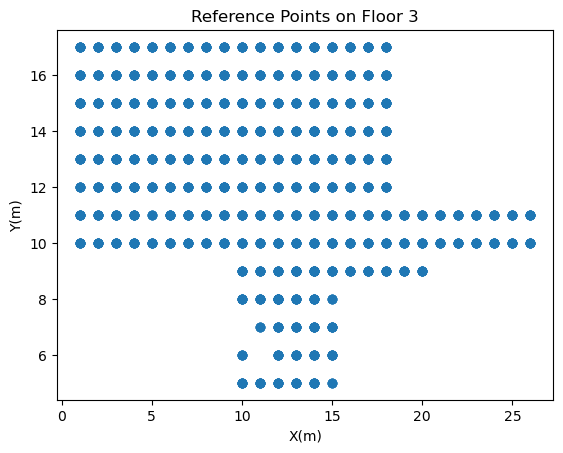

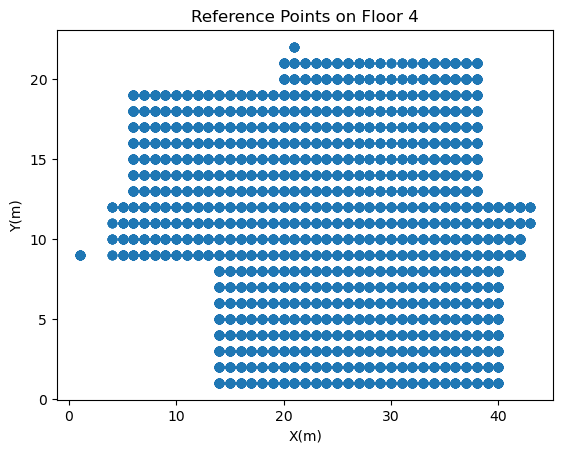

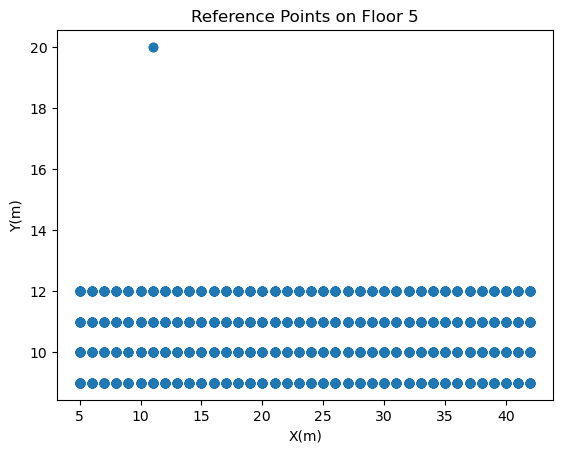

In [17]:
plot_floor_data(df_3rd_floor, 3)
plot_floor_data(df_4th_floor, 4)
plot_floor_data(df_5th_floor, 5)

We will take the 4th floor since it contains the highest number of rows

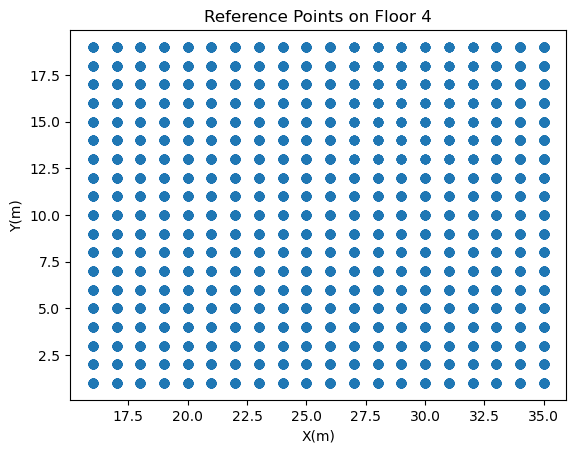

In [25]:
square_df = df_4th_floor[(df_4th_floor['X'] >= 16) & (df_4th_floor['X'] <= 35) & (df_4th_floor['Y'] >= 0) & (df_4th_floor['Y'] <= 19)]
plot_floor_data(square_df, 4)

In [43]:
square_df.head(3)

,Cid,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,...,AP170,AP171,AP172,Rs,Hpr,Did,Ts,floor,X,Y
256,L4-34-1,-80.0,-81.0,-70.0,-63.0,-85.0,-75.0,-69.0,NaN,NaN,...,NaN,NaN,NaN,0,0,D4,1469963153060,4,34,1
257,L4-34-1,-80.0,-81.0,-70.0,-63.0,-85.0,-75.0,-69.0,NaN,NaN,...,NaN,NaN,NaN,0,0,D4,1470139819109,4,34,1
258,L4-34-1,-80.0,-80.0,-70.0,-63.0,-85.0,-75.0,-69.0,NaN,NaN,...,NaN,NaN,NaN,0,0,D4,1469962304939,4,34,1


In [29]:
null_percent = (square_df == -110).sum() / len(df) * 100
print(null_percent)

Cid      0.000000
AP001    5.496988
AP002    5.480254
AP003    0.485274
AP004    4.133199
           ...   
Did      0.000000
Ts       0.000000
floor    0.000000
X        0.000000
Y        0.000000
Length: 180, dtype: float64


In [30]:
square_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10379 entries, 256 to 23847
Columns: 180 entries, Cid to Y
dtypes: int64(178), object(2)
memory usage: 14.3+ MB


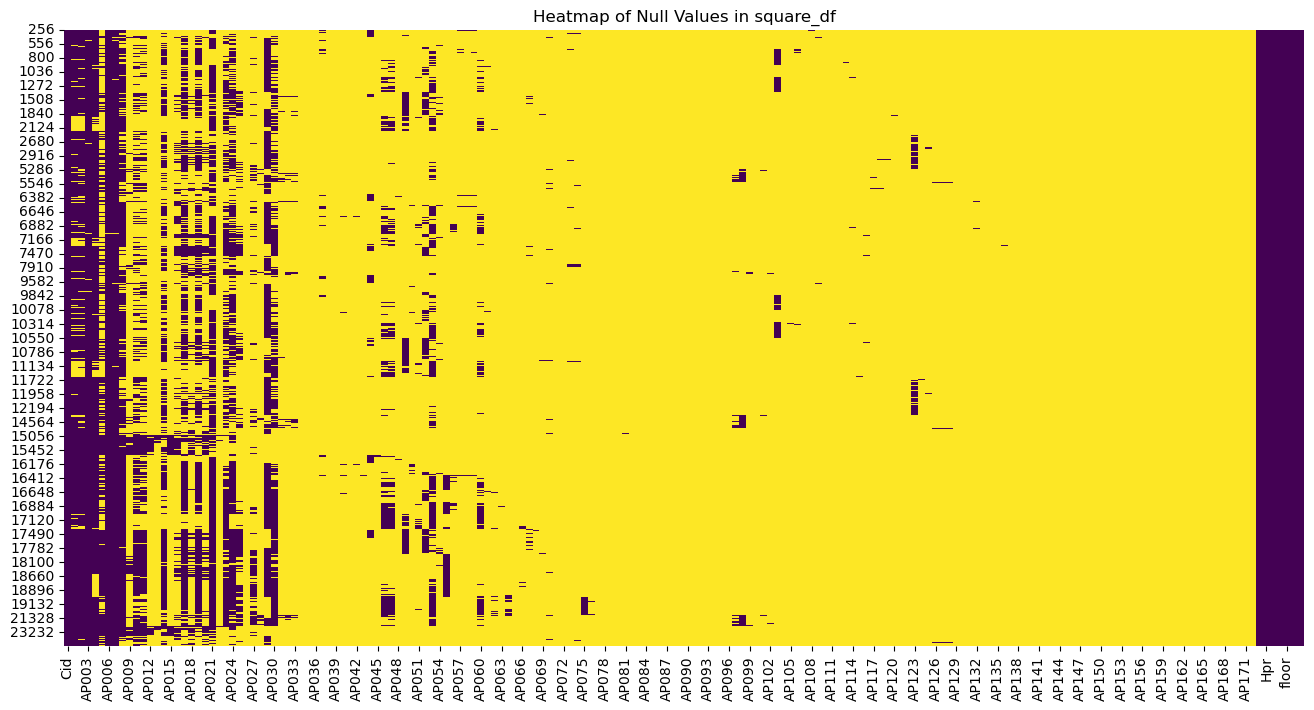

In [32]:
square_df = square_df.replace(-110, np.nan)
plt.figure(figsize=(16, 8))
sns.heatmap(square_df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Null Values in square_df')
plt.show()

In [42]:
square_df.isna().sum().head(10)

Cid         0
AP001    1314
AP002    1310
AP003     116
AP004     988
AP005    5689
AP006      48
AP007     122
AP008    2022
AP009    9311
dtype: int64

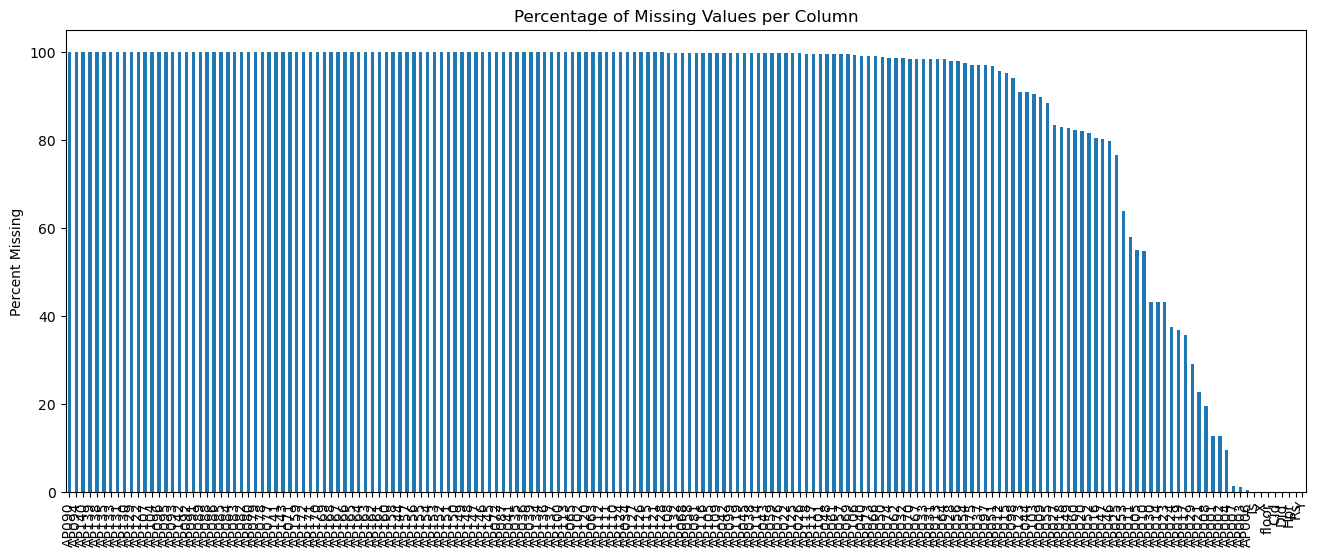

In [45]:
(square_df.isna().sum().sort_values(ascending=False) / len(square_df) * 100).plot(kind='bar', figsize=(16, 6), ylabel='Percent Missing')
plt.title('Percentage of Missing Values per Column')
plt.show()

In [44]:
square_df.shape

(10379, 180)

In [51]:
null_percent = square_df.isna().sum() / len(square_df) * 100
cols_to_drop = null_percent[null_percent > 60].index
square_df_cleaned = square_df.drop(columns=cols_to_drop)
square_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10379 entries, 256 to 23847
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Cid     10379 non-null  object 
 1   AP001   9065 non-null   float64
 2   AP002   9069 non-null   float64
 3   AP003   10263 non-null  float64
 4   AP004   9391 non-null   float64
 5   AP005   4690 non-null   float64
 6   AP006   10331 non-null  float64
 7   AP007   10257 non-null  float64
 8   AP008   8357 non-null   float64
 9   AP010   4696 non-null   float64
 10  AP011   4383 non-null   float64
 11  AP014   5904 non-null   float64
 12  AP017   6675 non-null   float64
 13  AP019   6559 non-null   float64
 14  AP021   8028 non-null   float64
 15  AP023   5909 non-null   float64
 16  AP024   6486 non-null   float64
 17  AP029   7359 non-null   float64
 18  AP030   5903 non-null   float64
 19  Rs      10379 non-null  int64  
 20  Hpr     10379 non-null  int64  
 21  Did     10379 non-null  object 
 22  T

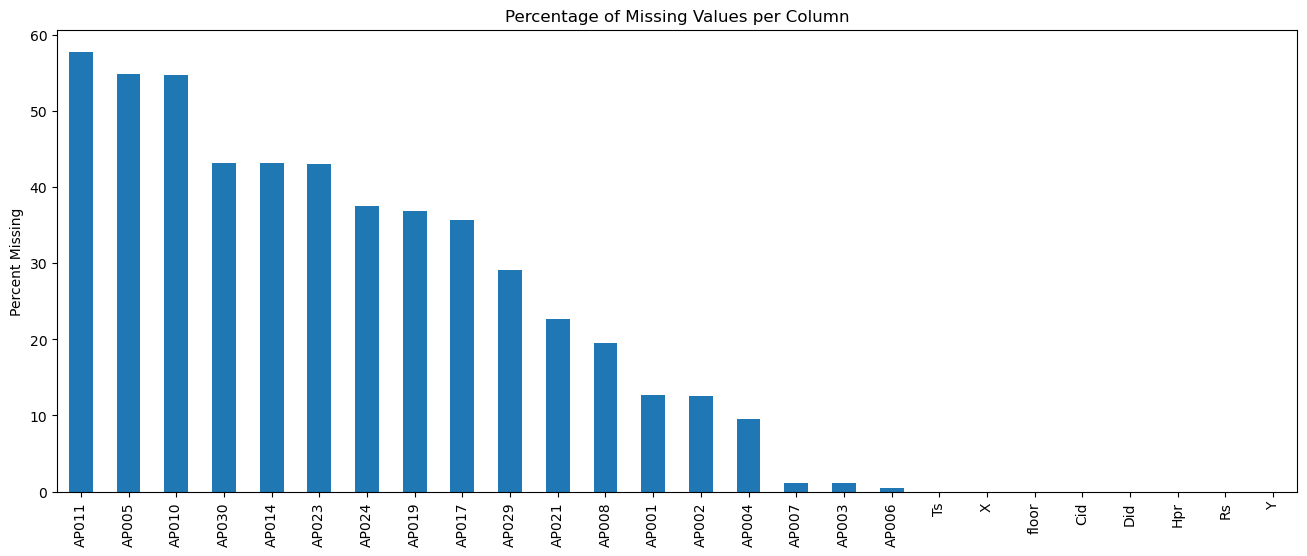

In [52]:
(square_df_cleaned.isna().sum().sort_values(ascending=False) / len(square_df_cleaned) * 100).plot(kind='bar', figsize=(16, 6), ylabel='Percent Missing')
plt.title('Percentage of Missing Values per Column')
plt.show()

In [53]:
square_df_cleaned.shape

(10379, 26)

In [ ]:
square_df_cleaned.columns

Index(['Cid', 'AP001', 'AP002', 'AP003', 'AP004', 'AP005', 'AP006', 'AP007',
       'AP008', 'AP009',
       ...
       'AP170', 'AP171', 'AP172', 'Rs', 'Hpr', 'Did', 'Ts', 'floor', 'X', 'Y'],
      dtype='object', length=180)

In [64]:
ap_cols = [col for col in square_df_cleaned.columns if col.startswith('AP')]
null_stats_ap_by_did = square_df_cleaned.groupby('Did')[ap_cols].apply(lambda group: group.isna().mean().mean() * 100)
print(null_stats_ap_by_did)

Did
D1    33.580165
D2    17.231222
D3    34.256210
D4    34.431077
dtype: float64


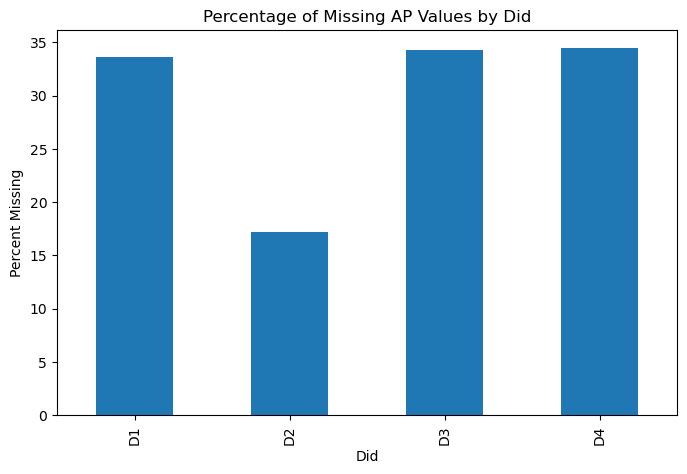

In [ ]:
null_stats_ap_by_did.plot(kind='bar', figsize=(8, 5), ylabel='Percent Missing')
plt.title('Percentage of Missing AP Values by Did')
plt.show()

In [66]:
null_stats_ap_by_hpr = square_df_cleaned.groupby('Hpr')[ap_cols].apply(lambda group: group.isna().mean().mean() * 100)
print(null_stats_ap_by_hpr)

Hpr
0    30.696944
1    27.399360
dtype: float64


In [67]:
null_stats_ap_by_rs = square_df_cleaned.groupby('Rs')[ap_cols].apply(lambda group: group.isna().mean().mean() * 100)
print(null_stats_ap_by_rs)

Rs
0    29.656059
1    27.978358
dtype: float64


In [68]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(square_df_cleaned[ap_cols].fillna(0))

component_names = [f'PC{i+1}' for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head(3)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
0,84.998098,-108.844256,7.844414,22.737931,20.261221,58.833090,51.558517,24.459815,-47.018888,16.052920,-40.747436,-1.053944,-5.588948,1.803746,-16.420034,-0.844117,-0.135707,-2.856805
1,84.998098,-108.844256,7.844414,22.737931,20.261221,58.833090,51.558517,24.459815,-47.018888,16.052920,-40.747436,-1.053944,-5.588948,1.803746,-16.420034,-0.844117,-0.135707,-2.856805
2,85.088173,-108.770486,7.726923,22.616446,20.691536,58.403599,51.687328,24.441629,-47.021640,16.124249,-40.682572,-1.278109,-5.484695,1.801778,-16.449625,-0.139726,-0.077276,-2.835733


In [70]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=square_df_cleaned[ap_cols].columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
AP001,0.095419,0.073738,-0.122826,-0.113289,0.434783,-0.437421,0.133908,-0.026513,0.004455,0.049734,0.069961,-0.225415,0.016427,-0.018482,-0.069660,-0.701194,-0.047501,-0.030602
AP002,0.090076,0.073770,-0.117491,-0.121485,0.430315,-0.429491,0.128812,-0.018186,-0.002753,0.071329,0.064864,-0.224164,0.104253,-0.001968,-0.029591,0.704390,0.058431,0.021072
AP003,-0.013603,0.060638,-0.020876,-0.022567,0.038039,0.024345,0.001725,0.040827,-0.014408,0.041878,0.037370,-0.035277,0.048788,0.054671,0.587813,0.039387,-0.505852,-0.615264
AP004,0.036635,-0.051067,-0.097551,-0.077075,0.238839,-0.267800,-0.090979,0.029785,-0.076932,-0.080777,-0.146879,0.854852,-0.265647,0.033434,0.077154,0.015214,0.002853,-0.001200
AP005,0.351733,0.418846,0.195641,0.004544,-0.105170,-0.046538,-0.044998,-0.129360,-0.193737,-0.532289,0.549927,0.063017,-0.033335,0.042255,-0.014476,0.012273,0.003234,-0.006852
AP006,-0.016742,0.060755,-0.022367,-0.026693,0.035787,0.015379,0.006853,0.031703,-0.005746,0.031430,0.045271,-0.030972,0.036392,0.045859,0.522023,-0.023347,-0.314682,0.782759
AP007,-0.009351,0.054338,-0.019824,-0.026934,0.034379,0.034536,0.022738,0.057219,0.008153,0.030533,0.042753,-0.027863,0.050439,0.048270,0.574060,-0.077902,0.799025,-0.084528
AP008,0.146117,0.024873,0.018043,-0.063572,0.383793,0.408495,0.051156,0.787952,0.039116,-0.131719,0.060175,-0.015212,-0.048986,0.019721,-0.100721,0.003881,-0.017738,0.004380
AP010,0.369810,0.391734,0.164307,-0.044074,-0.065728,0.021577,-0.062118,0.041964,-0.552893,0.271433,-0.526384,-0.094369,-0.061640,0.030317,-0.011727,-0.006440,0.011709,0.007299
AP011,0.337582,0.403055,0.140086,-0.088451,-0.149111,-0.052626,0.037555,0.027339,0.756503,0.256500,-0.090415,0.134732,0.026555,-0.058592,-0.016938,-0.000038,-0.011465,-0.001963


In [71]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

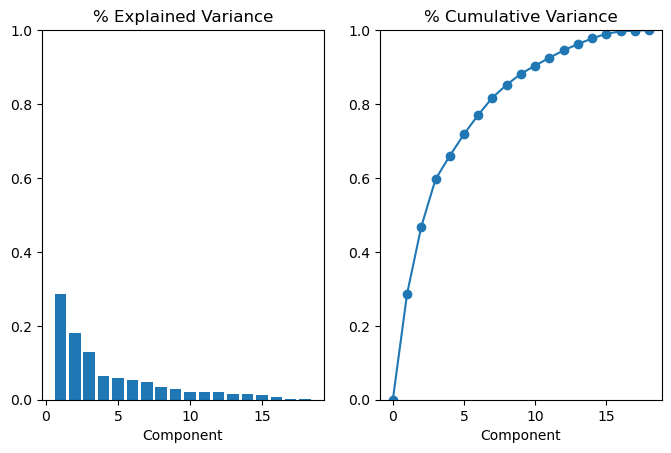

In [72]:
plot_variance(pca);

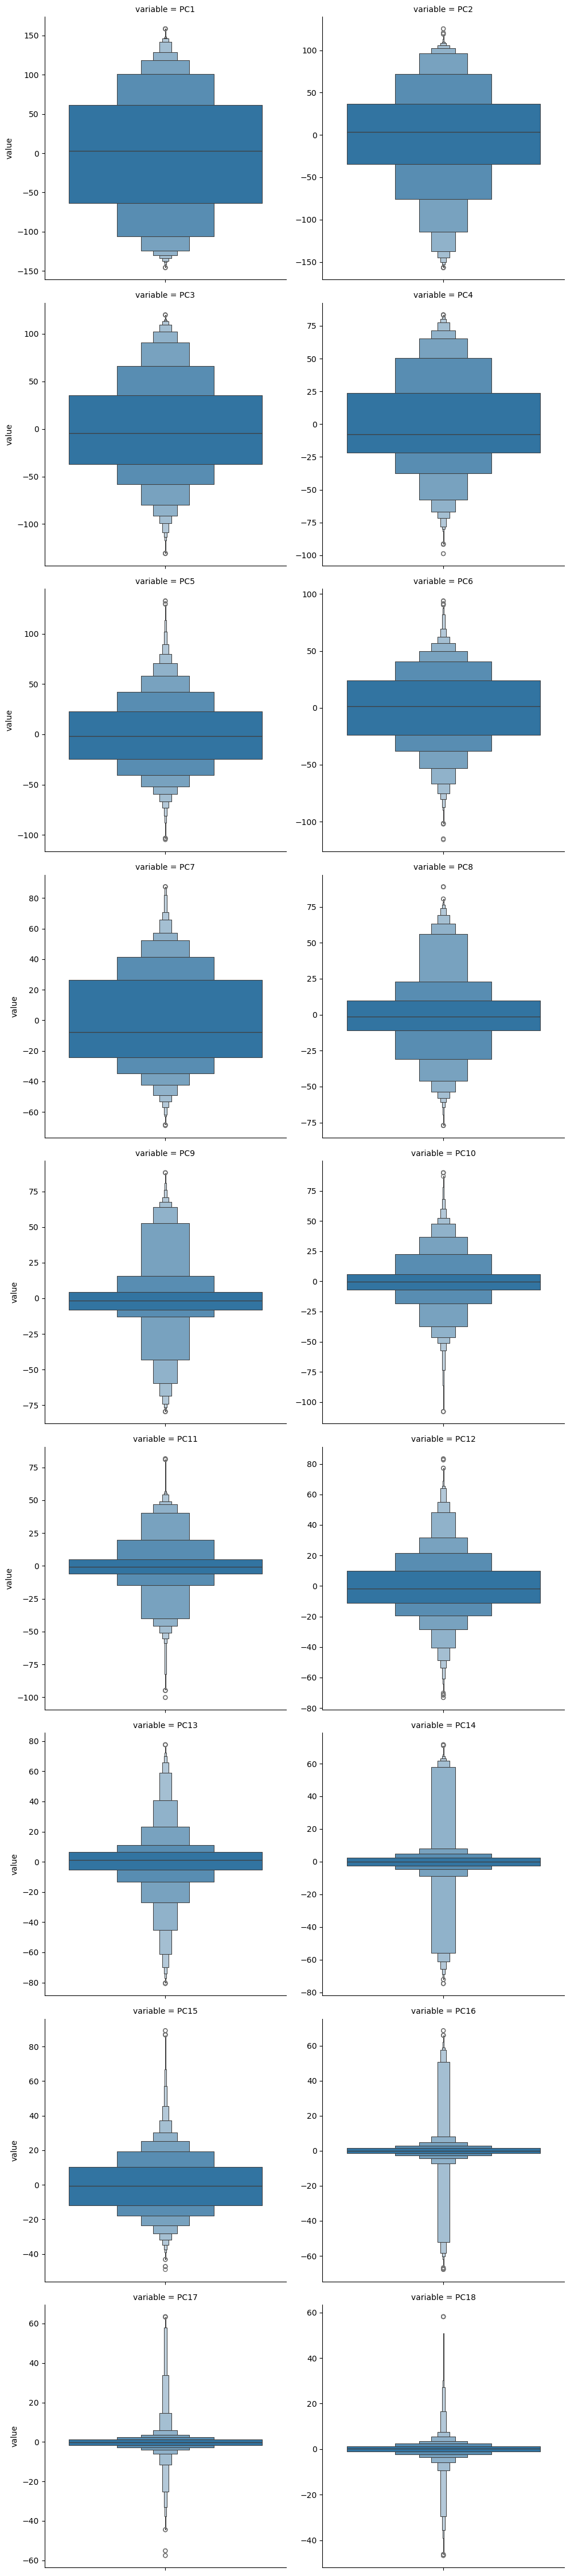

In [73]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);